In [1]:
import numpy as np

def mask2rotate_box(mask, with_module=True):
    """
    :param bbox: The polygon stored in format [x1, y1, x2, y2, x3, y3, x4, y4]
            shape [num_boxes, 8]
    :return: Rotated Rectangle in format [cx, cy, w, h, theta]
            shape [num_rot_recs, 5]
    """
    # print('bbox: ', bbox)
    bbox = np.array(mask,dtype=np.float32)
    bbox = np.reshape(bbox,newshape=(-1, 2, 4),order='F')
    # angle = math.atan2(-(bbox[0,1]-bbox[0,0]),bbox[1,1]-bbox[1,0])
    # print('bbox: ', bbox)
    angle = np.arctan2((bbox[:, 1, 0] - bbox[:, 1, 1]),bbox[:, 0, 1] - bbox[:, 0, 0])
    # angle = np.arctan2(-(bbox[:, 0,1]-bbox[:, 0,0]),bbox[:, 1,1]-bbox[:, 1,0])
    # center = [[0],[0]] ## shape [2, 1]
    # print('angle: ', angle)
    center = np.zeros((bbox.shape[0], 2, 1))
    for i in range(4):
        center[:, 0, 0] += bbox[:, 0,i]
        center[:, 1, 0] += bbox[:, 1,i]

    center = np.array(center,dtype=np.float32)/4.0

    # R = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]], dtype=np.float32)
    R = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]], dtype=np.float32)
    
    t_bbox = bbox - center
    # according to right-hand coordinate, y axis and x axis of image should switch with each other
    t_bbox = np.flip(t_bbox, 1)
    
    # reverse rotate
    normalized = np.matmul(R.transpose((2, 1, 0)), t_bbox)

    ymin = np.min(normalized[:, 0, :], axis=1)
    ymax = np.max(normalized[:, 0, :], axis=1)
    xmin = np.min(normalized[:, 1, :], axis=1)
    xmax = np.max(normalized[:, 1, :], axis=1)

    w = xmax - xmin + 1
    h = ymax - ymin + 1

    w = w[:, np.newaxis]
    h = h[:, np.newaxis]
    # TODO: check it
    if with_module:
        angle = angle[:, np.newaxis] % ( 2 * np.pi)
    else:
        angle = angle[:, np.newaxis]
    dboxes = np.concatenate((center[:, 0].astype(np.float), center[:, 1].astype(np.float), w, h, angle), axis=1)
    return dboxes



# Plot the coco annotation with keypoints and rotated bbox

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
P0457__1__492___369.png


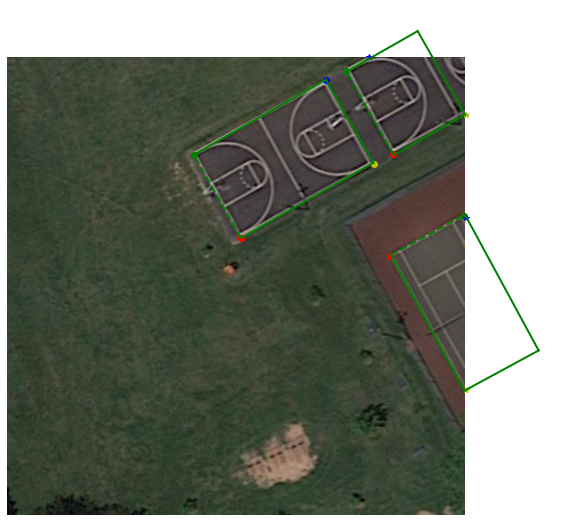

P0822__1__0___0.png


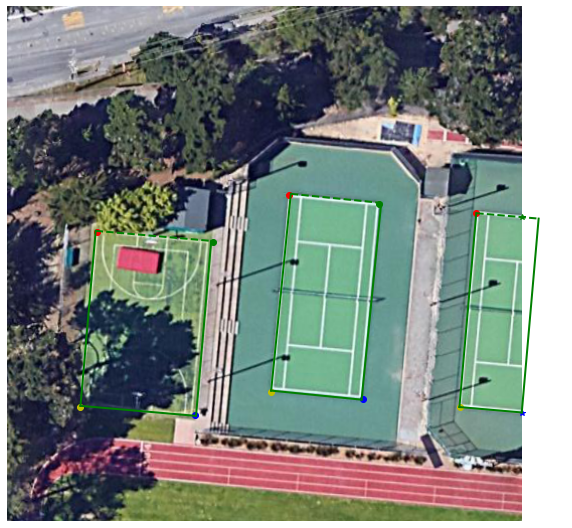

In [21]:
import os
import math

from pycocotools.coco import COCO
from skimage import io
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0) # 单位是inches

colors = ['r', 'g', 'b', 'y', 'c']

json_file = '/data/jifangcheng/datasets/dota/val512_k/val512.json'
dataset_dir = '/data/jifangcheng/datasets/dota/val512_k/images/'
coco = COCO(json_file)
# wordname_16 = ['plane', 'small-vehicle', 'large-vehicle', 'ship', 'tennis-court',
#                 'basketball-court', 'soccer-ball-field', 'helicopter', 'container-crane']
catIds = coco.getCatIds(catNms=['tennis-court',  'basketball-court']) # catIds=1 表示人这一类
imgIds = coco.getImgIds(catIds=catIds ) # 图片id，许多值
for i in range(len(imgIds)):
    img = coco.loadImgs(imgIds[i])[0]
    I = io.imread(dataset_dir + img['file_name'])
    print(img['file_name'])
    plt.axis('off')
    plt.imshow(I) #绘制图像，显示交给plt.show()处理
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    # plot the keypoint
    for ann in anns:
        points = ann['segmentation'][0]
        assert(len(points) >= 8)
        visibility = ann['visibility']
        for j in range(4):
            t = 'o' if visibility[j] == 1 else '*'
            plt.plot(points[2*j], points[2*j + 1], t, color=colors[j])
            
#         rotated_bbox = mask2rotate_box(points, False)[0]
        rotated_bbox = ann['rotated_bbox']
    
        # draw rotated box
        cnt_x, cnt_y, w, h, angle = rotated_bbox
        
        # theta = angle * math.pi / 180.0
        theta = angle
        c = math.cos(theta)
        s = math.sin(theta)
        rect = [(-w / 2, h / 2), (-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2)]
        # x: left->right ; y: top->down
        rotated_rect = [(s * yy + c * xx + cnt_x, c * yy - s * xx + cnt_y) for (xx, yy) in rect]
#         rotated_rect = [(c * xx - s * yy + cnt_x, s * xx + c * yy + cnt_y) for (xx, yy) in rect]
        for k in range(4):
            j = (k + 1) % 4
            plt.plot(
                [rotated_rect[k][0], rotated_rect[j][0]],
                [rotated_rect[k][1], rotated_rect[j][1]],
                color='g',
                linestyle="--" if k == 1 else '-',
                linewidth=2,
            )
            
#     coco.showAnns(anns)
    plt.show() #显示图像
    
    if i >= 1:
        break

# Filter the COCO json by categories

In [22]:
new_dataset_name = 'train512_k'
json_file = f'/data/jifangcheng/datasets/dota/{new_dataset_name}/train512.json'
out_json_file = f'/data/jifangcheng/datasets/dota/{new_dataset_name}/tennis_basketball_court.json'
dataset_dir = f'/data/jifangcheng/datasets/dota/{new_dataset_name}/images/'
coco = COCO(json_file)

# wordname_16 = ['plane', 'small-vehicle', 'large-vehicle', 'ship', 'tennis-court',
#                 'basketball-court', 'soccer-ball-field', 'helicopter', 'container-crane']

cat_ids = coco.getCatIds(catNms=['tennis-court', 'basketball-court']) 

img_ids = []
for cat_id in cat_ids:
    img_ids.extend(coco.getImgIds(catIds=cat_id)) # 图片id，许多值
img_ids = set(img_ids)

ann_ids = coco.getAnnIds(catIds=cat_ids)

print('cat_ids', cat_ids)
print('image ids: ', len(img_ids))
print('ann ids: ', len(ann_ids))

data_dict = {}

data_dict['images'] = coco.loadImgs(img_ids)
assert(len(data_dict['images']) == len(img_ids))

data_dict['annotations'] = coco.loadAnns(ann_ids)
assert(len(data_dict['annotations']) == len(ann_ids))

data_dict['categories'] = coco.loadCats(cat_ids)
assert(len(data_dict['categories']) == len(cat_ids))

import json
with open(out_json_file, 'w') as ff:
    json.dump(data_dict, ff)

loading annotations into memory...
Done (t=3.51s)
creating index...
index created!
cat_ids [5, 6]
image ids:  1569
ann ids:  5659


# Convert origin image to defined type to get rotated bbox

In [1]:
# convert objects to oriented box
import numpy as np
import math

def distance(point1, point2):
    return math.sqrt(pow(point1[0] - point2[0], 2) + pow(point1[1] - point2[1], 2))

def points2rotate_box(points, visibility):
#     points = np.array(points, dtype=np.float32)
    # calculate angle
    if visibility[0] == 0 and visibility[1] == 0:
        # todo: use 2, 3,  arctan2((y3 - y2) / (x2 - x3))
        angle = np.arctan2(points[7] - points[5], points[4] - points[6])
    else:    # calculate angle by #1,2 points,  arctan2((y0 - y1) / (x1 - x0))
        angle = np.arctan2((points[1] - points[3]),points[2] - points[0])
    
#     print(angle * 180 / math.pi)
        
    # calculate width and height
    keep = np.array(visibility, dtype=np.int32)
    if visibility[0] + visibility[1] == 2 or visibility[2] + visibility[3] == 2:
        height1 = distance((points[0], points[1]), (points[6], points[7]))
        height2 = distance((points[2], points[3]), (points[4], points[5]))
        if height1 > height2:
            keep[0] = 1
            keep[3] = 1
        else:
            keep[1] = 1
            keep[2] = 1
        height = max(height1, height2)
        width = distance((points[0], points[1]), (points[2], points[3])) if visibility[0] == 1 \
            else distance((points[4], points[5]), (points[6], points[7]))
    elif visibility[0] + visibility[3] == 2 or visibility[1] + visibility[2] == 2:
        width1 = distance((points[0], points[1]), (points[2], points[3]))
        width2 = distance((points[4], points[5]), (points[6], points[7]))
        if width1 > width2:
            keep[0] = 1
            keep[1] = 1
        else:
            keep[2] = 1
            keep[3] = 1
        width = max(width1, width2)
        height = distance((points[0], points[1]), (points[6], points[7])) if visibility[0] == 1 \
            else distance((points[2], points[3]), (points[4], points[5]))
    else:
        raise Exception("Exception occured when calculate rotate box!!")
        
    assert np.sum(keep) >= 3
    if keep[0] == 0 or keep[2] == 0:
        center_x = (points[2] + points[6]) / 2.0
        center_y = (points[3] + points[7]) / 2.0
    else:
        center_x = (points[0] + points[4]) / 2.0
        center_y = (points[1] + points[5]) / 2.0
    
    return center_x, center_y, width, height, angle

/data/jifangcheng/datasets/dota/val512_k/images/P2779__1__492___492.png
[{'name': 'small-vehicle', 'difficult': '0', 'poly': [140.0, 80.0, 153.0, 68.0, 185.0, 94.0, 171.0, 110.0], 'flag': [1, 1, 1, 1]}, {'name': 'small-vehicle', 'difficult': '0', 'poly': [418.0, 464.0, 437.0, 502.0, 457.0, 492.0, 438.0, 454.0], 'flag': [1, 1, 1, 1]}, {'name': 'small-vehicle', 'difficult': '2', 'poly': [505.0, 448.0, 492.0, 456.0, 505.0, 448.0, 492.0, 456.0], 'flag': [1, 0, 0, 1]}, {'name': 'small-vehicle', 'difficult': '2', 'poly': [415.0, 478.0, 398.0, 489.0, 415.0, 478.0, 398.0, 489.0], 'flag': [1, 0, 0, 1]}, {'name': 'large-vehicle', 'difficult': '2', 'poly': [353.0, 492.0, 379.0, 475.0, 353.0, 492.0, 379.0, 475.0], 'flag': [1, 0, 0, 1]}, {'name': 'large-vehicle', 'difficult': '2', 'poly': [331.0, 40.0, 310.0, 50.0, 280.0, 0.0, 308.0, 0.0], 'flag': [1, 1, 0, 0]}, {'name': 'large-vehicle', 'difficult': '0', 'poly': [244.0, 272.0, 255.0, 290.0, 163.0, 347.0, 151.0, 329.0], 'flag': [1, 1, 1, 1]}, {'nam

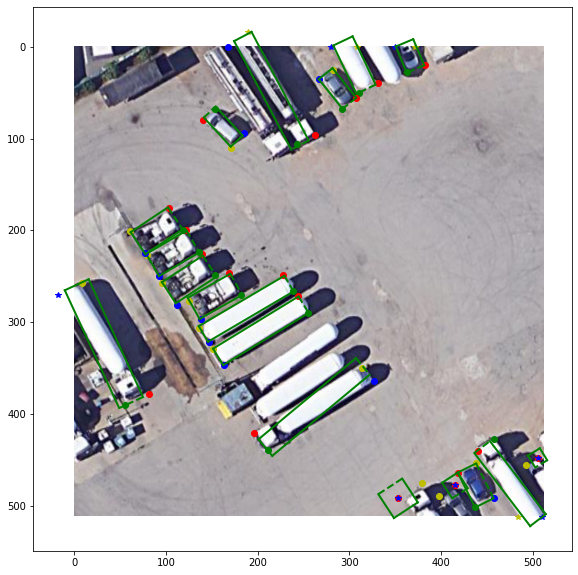

In [8]:
images_dir = '/data/jifangcheng/datasets/dota/val512_k/images/'
labels_dir = '/data/jifangcheng/datasets/dota/val512_k/labelTxt/'

from glob import glob
from skimage import io
from matplotlib import pyplot as plt
from itertools import chain
plt.rcParams['figure.figsize'] = (10.0, 10.0) # 单位是inches

colors = ['r', 'g', 'b', 'y', 'c', 'm']

# image_list = glob(images_dir + "*.png")[200:300]
image_list = ['/data/jifangcheng/datasets/dota/val512_k/images/P2779__1__492___492.png']
for img_path in image_list:
    print(img_path)
    label_path = img_path.replace('png', 'txt').replace('images', 'labelTxt')
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    I = io.imread(img_path)
    plt.imshow(I) #绘制图像，显示交给plt.show()处理
    
    objects = []
    for line in lines:
        splitlines = line.strip().split(' ')
        object_struct = {}
        if (len(splitlines) < 14):
            continue
        
        object_struct['name'] = splitlines[-2]
        object_struct['difficult'] = splitlines[-1]
        
        assert (len(splitlines) - 2) % 3 == 0
        num_points = (len(splitlines) - 2) // 3
        object_struct['poly'] = []
        object_struct['flag'] = []
        for i in range(num_points):
            object_struct['poly'].append((float(splitlines[2 * i]), float(splitlines[2 * i + 1])))
            object_struct['flag'].append(int(splitlines[2 * num_points + i]))
        
        object_struct['poly'] = list(chain(*object_struct['poly']))
        objects.append(object_struct)
    
    print(objects)
    # plot objects
    for obj in objects:
        for i in range(len(obj['flag'])):
            t = 'o' if obj['flag'][i] == 1 else '*'
            plt.plot(obj['poly'][2*i], obj['poly'][2*i + 1], t, color=colors[i])
        
        rotated_box = points2rotate_box(obj['poly'], obj['flag'])
        
        # draw rotated box
        cnt_x, cnt_y, w, h, theta = rotated_box
        c = math.cos(theta)
        s = math.sin(theta)
        rect = [(-w / 2, h / 2), (-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2)]
        # x: left->right ; y: top->down
        rotated_rect = [(s * yy + c * xx + cnt_x, c * yy - s * xx + cnt_y) for (xx, yy) in rect]
        for k in range(4):
            j = (k + 1) % 4
            plt.plot(
                [rotated_rect[k][0], rotated_rect[j][0]],
                [rotated_rect[k][1], rotated_rect[j][1]],
                color='g',
                linestyle="--" if k == 1 else '-',
                linewidth=2,
            )
            
    plt.show()

In [40]:
import os
import codecs
import numpy as np
import math
from dota_utils import GetFileFromThisRootDir
import cv2
import shapely.geometry as shgeo
import dota_utils as util
import copy
from multiprocessing import Pool
from functools import partial
import time
from itertools import chain

def choose_best_pointorder_fit_another(poly1, poly2):
    """
        To make the two polygons best fit with each point
    """
    x1 = poly1[0]
    y1 = poly1[1]
    x2 = poly1[2]
    y2 = poly1[3]
    x3 = poly1[4]
    y3 = poly1[5]
    x4 = poly1[6]
    y4 = poly1[7]
    combinate = [np.array([x1, y1, x2, y2, x3, y3, x4, y4]), np.array([x2, y2, x3, y3, x4, y4, x1, y1]),
                 np.array([x3, y3, x4, y4, x1, y1, x2, y2]), np.array([x4, y4, x1, y1, x2, y2, x3, y3])]
    dst_coordinate = np.array(poly2)
    distances = np.array([np.sum((coord - dst_coordinate)**2) for coord in combinate])
    sorted = distances.argsort()
    return combinate[sorted[0]]

                     
def adjust_object(inter_poly, obj_poly, vis_flags):
    # calculate the at least 2 points
    obj2inter = {}
    for i, flag in enumerate(vis_flags):
        if flag == 1:
            error = []
            for j in range(len(inter_poly)):
                error.append(pow(obj_poly[2 * i] - inter_poly[j][0], 2) + pow(obj_poly[2 * i + 1] - inter_poly[j][1], 2))
            min_idx = np.array(error).argsort()[0]
            obj2inter[i] = min_idx
    assert len(obj2inter) >= 2
    print(obj2inter)

    # select the 4 points
    inter_idxes = []
    if vis_flags[0] == 1 and vis_flags[3] == 1:
        inter_idxes.append(obj2inter[3] - 1)
        inter_idxes.append(obj2inter[3])
        inter_idxes.append(obj2inter[0])
        inter_idxes.append((obj2inter[0] + 1) % len(inter_poly))
    else:
        for i, flag in enumerate(vis_flags):
            if flag == 1 and vis_flags[i - 1] != 1:
                inter_idxes.append(obj2inter[i] - 1)
                inter_idxes.append(obj2inter[i])
            if flag == 1 and vis_flags[i - 1] == 1:
                inter_idxes.append(obj2inter[i])
                inter_idxes.append((obj2inter[i] + 1) % len(inter_poly))

    # sort
    out_poly = list(chain(*[inter_poly[idx] for idx in inter_idxes]))
    best_poly = choose_best_pointorder_fit_another(out_poly, obj_poly)
    return best_poly

## shapely api test

In [45]:
import shapely.geometry as shgeo

left = 0
right = 500
up = 0
down = 500

img_poly = shgeo.Polygon([(left, up), (right, up), (right, down),
                                 (left, down)])
obj_poly = [-10, 10, 40, -40, 120, 100, 80, 130]
object_poly = shgeo.Polygon([(-10, 10), (40, -40), (120, 100), (80, 130)])

obj_poly = [100, 100, 550, 40, 650, 350, 420, 430]
object_poly = shgeo.Polygon([(obj_poly[2 * i], obj_poly[2 * i + 1]) for i in range(len(obj_poly) // 2)])
vis_flags = [1, 0, 0, 1]

inter_poly = object_poly.intersection(img_poly)
print(inter_poly)

inter_poly = shgeo.polygon.orient(inter_poly, sign=1)
print(inter_poly)

out_poly = list(inter_poly.exterior.coords)[0: -1]
print(out_poly)

best_poly = adjust_object(out_poly, obj_poly, vis_flags)
print(best_poly)

POLYGON ((500 46.66666666666667, 100 100, 420 430, 500 402.1739130434783, 500 46.66666666666667))
POLYGON ((500 46.66666666666667, 500 402.1739130434783, 420 430, 100 100, 500 46.66666666666667))
[(500.0, 46.66666666666667), (500.0, 402.17391304347825), (420.0, 430.0), (100.0, 100.0)]
{0: 3, 3: 2}
[100.         100.         500.          46.66666667 500.
 402.17391304 420.         430.        ]


351.75 210.25
280.8629559055448 383.6000521376398
